In [4]:
# %cd drive/MyDrive/Colab\ Notebooks/COMP8420

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/COMP8420'
/content/drive/MyDrive/Colab Notebooks/COMP8420


## Import modules

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from pandas import DataFrame

In [6]:
import os
from tqdm.notebook import tqdm
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings("ignore")

## Data related function

In [7]:
def load_data(path:str, mode:str)-> DataFrame:
    """This function load data from specific data file based on mode

    Args:
        path (str): path to folder contains data file
        mode (str): what data to be loaded

    Returns:
        DataFrame: DataFrame contains all data
    """
    assert mode in ["gsr", "pupil", "skin", "all"], f"mode should be 'gsr','pupil','all'. Not {mode}"
    # read data gsr
    if mode in ['gsr', 'all']:
        df_gsr = pd.read_excel(path+'gsr_features.xlsx',sheet_name='data')
        df_gsr.columns = ['patient'] + list(df_gsr.columns)[1:]
        if mode == 'gsr':
            return df_gsr
    # read pupil data
    if mode in ['pupil', 'all']:
        df_pupil = pd.read_excel(path+'pupil_features.xlsx',sheet_name='data')
        df_pupil.columns = ['patient'] + list(df_pupil.columns)[1:]
        if mode == 'pupil':
            return df_pupil
    # read skin temperature data
    if mode in ['skin', 'all']:
        df_skin = pd.read_excel(path+'skintemp_features.xlsx',sheet_name='data')
        df_skin.columns = ['patient'] + list(df_skin.columns)[1:]
        if mode == 'skin':
            return df_skin
    # in case of using all data, combine
    data = pd.concat([df_gsr,df_pupil,df_skin],axis = 1)
    # remove duplicated columns
    data = data.loc[:,~data.columns.duplicated()]
    return data

def train_val_test_split(data:DataFrame, test_patient:str, val_patient:str) -> Tuple[DataFrame,DataFrame,DataFrame]:
    """ This function is to create train, test and validation dataset using leave-one-patient-out

    Args:
        data (DataFrame): the dataset that contains all data point
        test_patient (str): patient choosen for testing
        val_patient (str): patient choosen for validation in training process

    Returns:
        Tuple[DataFrame,DataFrame,DataFrame]: train, validation, test dataframe
    """
    # check input
    assert test_patient in data.patient.unique(), f'{data.patient.unique().tolist()}'
    assert val_patient in data.patient.unique(), f'{data.patient.unique().tolist()}'
    # create train and test dataset
    df_test = data[data['patient'] == test_patient]
    df_train = data[(data['patient'] != test_patient)&((data['patient'] != val_patient))]
    df_val = data[data['patient'] == val_patient]
    # reset index
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop = True)
    # delete patient column
    if 'patient' in df_train.columns:
        del df_train['patient']
    if 'patient' in df_test.columns:
        del df_test['patient']  
    if 'patient' in df_val.columns:
        del df_val['patient']
    return df_train, df_val, df_test


def df_to_xy(df:DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """Convert dataframe to X and Y numpy array where X is input and Y is output

    Args:
        df (DataFrame): dataset to convert to numpy array

    Returns:
        Tuple[np.ndarray, np.ndarray]: X,Y
    """
    df = df.apply(pd.to_numeric)
    x = df.values[:,1:]
    y = df.values[:,0]
    return x,y

## Fixed Point Casper model

In [8]:
import torch.autograd as autograd

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        # layer that we want to find fixed point
        self.f = f
        # the solver that find fixed points
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros((x.shape[0],1)), **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z

class CascadeNeuron(nn.Module):
    """
        This class represent one hidden neuron in cascade network, use this for fixed point
    """
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, output_size,bias = False)
        self.fc2 = nn.Linear(output_size, output_size, bias = False)

    def forward(self, z, x):
        # print(x)
        x1 = self.fc1(x)
        # print(z)
        x2 = self.fc2(z)
        out = torch.sigmoid(x1+x2)
        return out


def anderson(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ 
    Anderson acceleration for fixed point iteration. 
    Thanks to http://implicit-layers-tutorial.org/deep_equilibrium_models/
    """
    bsz, d = x0.shape
    X = torch.zeros(bsz, m, d, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d, dtype=x0.dtype, device=x0.device)
    X[:,0] = x0.view(bsz, -1)
    
    F[:,0] = f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)
    
    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)
        
        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

In [9]:
class CasPer(nn.Module):
    def __init__(self, input_size, num_classes, input_hidden_layers, hidden_hidden_layers, hidden_output_layers):
        super().__init__()
        self.n_hidden_layers = 0
        self.fc1 = nn.Linear(input_size, num_classes)

        self.input_size = input_size
        self.num_classes = num_classes

        # Init number of n*(n+3)/2 layers for use
        self.input_hidden_layers = input_hidden_layers
        # self.hidden_hidden_layers = hidden_hidden_layers
        self.hidden_output_layers = hidden_output_layers

    def forward(self, x):
        outL3_1 = self.fc1(x)  # part of L3 weights, correlation of input and output
        if self.n_hidden_layers == 0:
            return outL3_1
        # when there exists a hidden neuron
        H = []                  # store hidden neuron value
        x_clone = x.clone()     # extend neuraon value to the end of this
        for i in range(self.n_hidden_layers):
            # print(x_clone.shape)
            # calculate first neuron
            if i == 0:
                h = self.input_hidden_layers[str(i)](x_clone)
                h = torch.sigmoid(h)
                H.append(h)
                continue
            # calculate other neuron value
            previous_neuron = H[i-1]
            # print(previous_neuron.shape)
            # ones = torch.tensor((x.shape[0],1),dtype=torch.float)
            x_clone = torch.cat([x_clone, previous_neuron], dim=1)
            # calculate next neuron value
            h = self.input_hidden_layers[str(i)](x_clone)
            h = torch.sigmoid(h)
            H.append(h)
        # calculate output
        total_out = outL3_1
        for h in H:
            total_out += self.hidden_output_layers[str(i)](h)
        return total_out
    
    def add_neuron(self, learning_rates = (0.2, 0.005, 0.001), deq = False):
        """
            Add new cascade neuron and return optimizer with different learning rate
            set deq = True when we want to used fixed point neuron instaed of normal neuron
        """
        # save total number of neuron
        self.n_hidden_layers += 1
        if deq:
            # edit DEQ
            f = CascadeNeuron(self.input_size + self.n_hidden_layers - 1, 1)
            # add new connection from input to new neuron
            self.input_hidden_layers[str(len(self.input_hidden_layers))] = DEQFixedPoint(f,anderson)
        else:
             # add new connection from input to new neuron
            self.input_hidden_layers[str(len(self.input_hidden_layers))] = nn.Linear(self.input_size + self.n_hidden_layers - 1, 1, bias = False)
        # add new connections from new neuron to output
        self.hidden_output_layers[str(len(self.hidden_output_layers))] = nn.Linear(1, self.num_classes, bias = False)
        # create new optimizer
        # L1 is for connection from input to new neuron
        # from input to new neuron
        L1_params_id = list(map(id, self.input_hidden_layers[str(len(input_hidden_layers)-1)].parameters()))
        # L2 is for connection from new neuron to output
        L2_params_id = list(map(id, self.hidden_output_layers[str(len(self.hidden_output_layers)-1)].parameters()))
        L1L2_id = L1_params_id + L2_params_id
        # L3 is everything else not in L1, L2 region
        L3_params = filter(lambda p: id(p) not in L1L2_id, self.parameters())
        # get learning rate for each region
        lr1, lr2, lr3 = learning_rates
        
        params = [
            {'params': L3_params, 'lr':lr3}, # L3
            {'params': self.input_hidden_layers[str(len(input_hidden_layers)-1)].parameters(), 'lr':lr1}, # L1
            {'params': self.hidden_output_layers[str(len(self.hidden_output_layers)-1)].parameters(), 'lr':lr2}, # L2
        ]      
        optimizer = torch.optim.RMSprop(params, momentum=0.9, weight_decay=0.00001, centered=True)
        # optimizer = optim.Adam(params)
        return optimizer

## Ultities

In [10]:
def accuracy(Y_pred, Y_target):
    """ Calculate accuracy of prediction (Y_pred) compared to truth label (Y_target)
    Args:
        Y_pred (torch.tensor): prediction tensor with size of [batch x num_class]
        Y_target (torch.tensor): truth tensor with size of [batch x 1]
    Returns:
        torch.float: the overall accuracy
    """
    # find number of correct label
    correct_num = (Y_pred.argmax(-1) == Y_target).int().sum()
    # calculate accuracy
    acc = correct_num.float()/Y_target.shape[0]
    return acc


def recall(Y_pred, Y_target, class_label):
    """ Calculate Recall
    Recall = TP/(TP+FN)
    Args:
        Y_pred (torch.tensor): prediction tensor with size of [batch x num_class]
        Y_target (torch.tensor): truth tensor with size of [batch x 1]
        claass_label (str): label of class that we want to calculate recall
    Returns:
        torch.float: recall of model
    """
    # get label prediction
    Y_pred = Y_pred.argmax(-1)
    # find all datapoint that is true for the class_label
    label_index = torch.where(Y_target == class_label)
    # find all correctly predicted label in this class
    correct_label = (Y_pred[label_index] == Y_target[label_index]).int().sum()
    # returnr recall
    return float(correct_label)/len(label_index[0])


def precision(Y_pred, Y_target, class_label):
    """ Calculate Precision
    Recall = TP/(TP+FP)
    Args:
        Y_pred (torch.tensor): prediction tensor with size of [batch x num_class]
        Y_target (torch.tensor): truth tensor with size of [batch x 1]
        claass_label (str): label of class that we want to calculate precision
    Returns:
        torch.float: precision of model
    """
    # get label prediction
    Y_pred = Y_pred.argmax(-1)
    # get all correct label index
    label_index = torch.where(Y_target == class_label)
    # get all correctly predicted label for the class label
    correct_label = (Y_pred[label_index] == Y_target[label_index]).int().sum()
    # return precision
    return float(correct_label)/max(len(torch.where(Y_pred == class_label)[0]),1)


def f1(recall, precision):
    """ Calculate F1 score
    F1 =  2 * precision * recall/(precision + recall)
    Args:
        recall (float): recall value
        precision (float): precision value
    Returns:
        float: f1 score
    """
    return 2 * recall * precision / max((recall + precision),1)


def validation(model, criterion, X_val, Y_val, test = False):
    """ Calculate all metrics of trained model
    Args:
        model (nn.Module): the model we need to evaluate
        criterion (nn.Module): loss function
        X_val (torch.tensor): input tensor used for validation with size of [batch x dimension]
        Y_val (torch.tensor): output tensor used for validation with size of [batch x 1]
        test (bool): set this to print output to debug/compare
    Returns:
        loss: loss function value
        acc: accuracy of model
        rc_all: recall for each class
        pr_all: precision for each class
        f1_all: F1 score for each class
    """
    # set model to evaluation mode
    model.eval()
    # calculate output
    outputs = model(X_val)
    # calculate loss_function
    loss = criterion(outputs, Y_val)
    # calculate accuracy
    acc = accuracy(outputs, Y_val)

    rc_all = []
    pr_all = []
    f1_all = []
    for i in range(4):
        # recall
        rc = recall(outputs, Y_val, i)
        # precision
        pr = precision(outputs, Y_val, i)
        # f1
        f1_value = f1(rc,pr)
        # Store result
        rc_all.append(rc)
        pr_all.append(pr)
        f1_all.append(f1_value)
    if test:
        print('Predict\t',outputs.argmax(-1))
        print('Test\t',Y_val)
    return loss, acc, rc_all, pr_all, f1_all

## Test number of neurons

In [ ]:
accu = []
for max_layer in tqdm(range(1,21)):
    # set this to true to use fixed point layer instead of normal layer
    deq_layer = True
    # 12321
    torch.manual_seed(12321)
    # 268
    np.random.seed(268)
    # load data set
    dataset = load_data('./data/', 'all')
    # get all the patient to perform leave one patient out
    patient_list = dataset.patient.unique().tolist()
    # store metrics data
    all_acc = []

    for patient in patient_list:
        # print(f'Choose patiet {patient} as testing patient')
        best_accuracy = 0
        best_val_p = None
        for val_p in patient_list:

            # get train, val, test data
            train, val, test = train_val_test_split(dataset, patient,val_p)
            # create x,y
            train_x, train_y = df_to_xy(train)
            val_x, val_y = df_to_xy(val)
            test_x, test_y = df_to_xy(test)
            # calculate normalize parameter
            mean_train_x = train_x.mean(axis=0)
            std_train_x = train_x.std(axis=0)
            # normalize data
            normalize_train_x = (train_x - mean_train_x)/std_train_x
            normalize_val_x = (val_x - mean_train_x)/std_train_x
            normalize_test_x = (test_x - mean_train_x)/std_train_x
            # convert to tensor
            X_train = torch.tensor(normalize_train_x, dtype=torch.float)
            Y_train = torch.tensor(train_y, dtype=torch.long)

            X_val = torch.tensor(normalize_val_x, dtype=torch.float)
            Y_val = torch.tensor(val_y, dtype=torch.long)

            input_size = 85
            output_size = 4

            input_hidden_layers = nn.ModuleDict()
            hidden_hidden_layers = nn.ModuleDict()
            hidden_output_layers = nn.ModuleDict()

            # model = CasPer(input_size, output_size, input_hidden_layers, hidden_hidden_layers, hidden_output_layers)
            model = CasPer(input_size, output_size, input_hidden_layers, hidden_hidden_layers, hidden_output_layers)
            model.add_neuron(deq = deq_layer)
            criterion = nn.CrossEntropyLoss()

            optimizer = optim.RMSprop(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00001, centered=True)
            # optimizer = optim.Adam(model.parameters())

            P = 2
            checkpoint_epoch = 15 + P * model.n_hidden_layers

            previous_loss = torch.tensor(float('inf'))
            all_loss = []

            num_epoch = 10000
            count = 0
            for epoch in range(num_epoch * 2):
                # if epoch %1000 == 0:
                #     clear_output()
                model.train()
                total = 0
                correct = 0
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, Y_train)
                all_loss.append(loss)
                if epoch == checkpoint_epoch:
                    N = model.n_hidden_layers
                    # when the loss not decrease by 1%, add new neron
                    if (previous_loss -loss).abs()/previous_loss < 0.005:
                        if N >= max_layer:
                            break
                        optimizer = model.add_neuron(deq = deq_layer)
                        N = model.n_hidden_layers
                        if checkpoint_epoch + (15+P*N) > num_epoch:
                            num_epoch += (15+P*N)
                    # print(previous_loss,loss)
                    previous_loss = loss
                    # train
                    Y_pred = outputs.argmax(-1)
                    # print('Treain accuracy',sum((Y_pred == Y_train).int())/len(Y_train))
                    checkpoint_epoch += 15 + P * N
            # validation
            val_loss, val_acc, rc_all, pr_all, f1_all = validation(model, criterion, X_val,Y_val,False)
            # save best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                torch.save(model.state_dict(), './best_model/{model_name}_{patient}.pth'.format(model_name=type(model).__name__, patient=patient))
                best_p_val = val_p

        # load best model to calculate accuracy
        model.load_state_dict(torch.load('./best_model/{model_name}_{patient}.pth'.format(model_name=type(model).__name__, patient=patient)))
        model.eval()
        # get train, val, test data
        train, val, test = train_val_test_split(dataset, patient,best_p_val)
        # create x,y
        train_x, train_y = df_to_xy(train)
        test_x, test_y = df_to_xy(test)
        # calculate normalize parameter
        mean_train_x = train_x.mean(axis=0)
        std_train_x = train_x.std(axis=0)
        # normalize data
        normalize_test_x = (test_x - mean_train_x)/std_train_x
        # convert to tensor
        X_test = torch.tensor(normalize_test_x, dtype=torch.float)
        Y_test = torch.tensor(test_y, dtype=torch.long)

        test_loss, test_acc, rc_all, pr_all, f1_all = validation(model, criterion, X_test,Y_test, False)
        all_acc.append(test_acc)
    print(max_layer,sum(all_acc)/len(all_acc))
    accu.append(sum(all_acc)/len(all_acc))

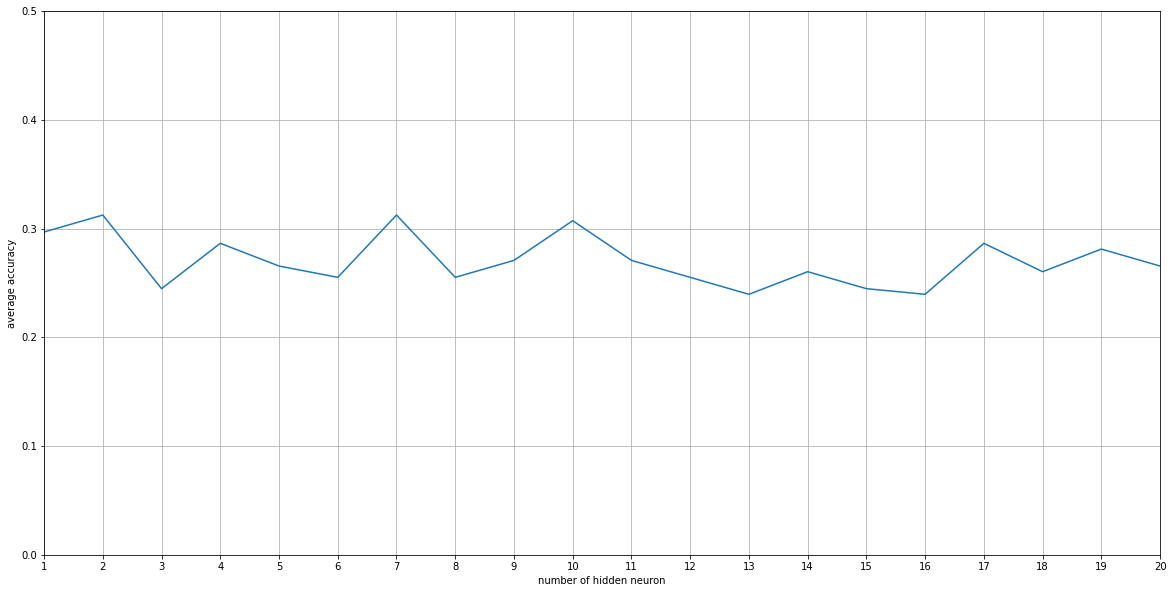

In [20]:
# this part is hand input because the training time was too long to run everything in one session in google colab
import matplotlib.pyplot as plt
accu = [0.2969,0.3125,0.2448,0.2865,0.2656,0.2552,0.3125,0.2552,0.2708,0.3073,0.2708,0.2552,0.2396,0.2604,0.2448,0.2396,0.2865,0.2604,0.2812,0.2656]
plt.figure(figsize=(20,10))
plt.plot(np.arange(1,21),accu)
plt.xlabel('number of hidden neuron')
plt.ylabel('average accuracy')
plt.ylim(0,0.5)
plt.xlim(1,20)
plt.xticks(np.arange(1,21))
plt.grid()
plt.show()